In [50]:
### GENERAL REQUIREMENTS - will install the libraries

import pandas as pd
import numpy as np
import math
import nltk
import requests
import re
import json
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [2]:
### configure session and groupurl
### in the case of "SDAM_root", the folder owner is Vojtech with username 648597@au.dk
conf = sddk.configure_session_and_url("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Roman Cities - Hanson (from online CSV) - merging
Feel free to skip to next section



In [3]:
### ROMAN CITIES AS A DATAFRAME
url = "http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv"
response = requests.get(url).text
file_object = io.StringIO(response)
cities_raw = pd.read_csv(file_object)
cities_raw.head(3) 

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...


In [4]:
cities_area = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Areas_OxREP.csv").text))
cities_area.head(3)

,Primary Key,Area,Estimate Basis
0,Hanson2016_1,16,Walls
1,Hanson2016_4,52,Inhabited area
2,Hanson2016_7,130,Walls


In [5]:
len(cities_area)

885

In [6]:
cities_status_raw = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Civic%20Status_OxREP.csv").text))
cities_status_raw.head(3)

,Primary Key,Civic Status,Notes
0,Hanson2016_1,Rights and privileges,libera
1,Hanson2016_4,Rights and privileges,libera
2,Hanson2016_8,Rights and privileges,libera et immunis


In [7]:
cities_status = pd.DataFrame(cities_status_raw.groupby("Primary Key")["Civic Status"].apply(list))
cities_status.head(5)

,Civic Status
Primary Key,
Hanson2016_1,[Rights and privileges]
Hanson2016_1000,[Municipium]
Hanson2016_1001,[Municipium]
Hanson2016_1002,"[Colonia, Municipium]"
Hanson2016_1003,[Municipium]


In [8]:
cities_monuments_raw = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Monuments_OxREP.csv").text))
cities_monuments_raw.head(3)

,Primary Key,Structure
0,Hanson2016_1,Acropolis
1,Hanson2016_1,Agora
2,Hanson2016_1,Temple of Apollo


In [9]:
print(len(cities_monuments_raw))
cities_monuments = pd.DataFrame(cities_monuments_raw.groupby("Primary Key")["Structure"].apply(list))
print(len(cities_monuments))

9472
1208


In [10]:
cities_monuments

,Structure
Primary Key,
Hanson2016_,[Agora?]
Hanson2016_1,"[Acropolis, Agora, Temple of Apollo, Theatre, ..."
Hanson2016_10,"[Acropolis, Gymnasium, Sanctuary of Poseidon, ..."
Hanson2016_100,"[Acropolis, Fountain, Gymnasium, Gymnasium, Hi..."
Hanson2016_1000,[Temple]
...,...
Hanson2016_993,"[Amphitheatre, Basilica, Baths?, Forum, Temple..."
Hanson2016_995,"[Aqueduct, Baths, Forum, Unidentified public b..."
Hanson2016_996,"[Temple, Walls]"


In [11]:
cities = pd.merge(cities_raw, cities_area, on="Primary Key", how="left") 
cities = pd.merge(cities, cities_status, on="Primary Key", how="left")
cities = pd.merge(cities, cities_monuments, on="Primary Key", how="left")
len(cities)

1388

In [12]:
def get_number_of_structures(row):
  try: num = len(row["Structure"])
  except: num = 0
  return num
cities["num_of_structures"] = cities.apply(lambda row: get_number_of_structures(row), axis=1)

In [13]:
sddk.write_file("SDAM_data/urban/hanson_2016_mergred.json", cities, conf)

A file with the same name ("hanson_2016_mergred.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/hanson_2016_mergred.json"


# To start with merged data

In [0]:
cities = sddk.read_file("SDAM_data/hanson_2016_mergred.json", "df", conf)

In [195]:
### ROMAN CITIES AS A GEODATAFRAME
cities = geopandas.GeoDataFrame(cities, geometry=geopandas.points_from_xy(cities["Longitude (X)"], cities["Latitude (Y)"]))
cities.drop(columns=["Longitude (X)", "Latitude (Y)"], inplace=True)
cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,geometry
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,POINT (22.93333 38.58333)
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,POINT (23.73409 38.08347)
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,POINT (23.21970 38.45261)
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,POINT (23.42850 37.75007)
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,NaN,None,None,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,POINT (22.35572 38.14795)


In [28]:
### the overall length of the dataset
len(cities)

1388

In [29]:
### number of cities with specified area
len(cities[cities["Area"].notnull()])

885

In [30]:
### number of cities with at least one monument
len(cities[cities["num_of_structures"]> 0])

1207

In [31]:
### number of cities with at least one monument & with specified area 
len(cities[(cities["num_of_structures"]> 0) & (cities["Area"].notnull())])

851

In [48]:
cities["Area"] = cities["Area"].astype(float)

In [49]:
### generate an ID (to be used for future merge)
cities["ID"] = cities.apply(lambda row: row["Primary Key"].partition("_")[2], axis=1)
cities.head(3)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,1
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.,NaN,NaN,NaN,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,2
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,NaN,NaN,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,3


# Population sizes from Hanson 2019

In [55]:
hanson2019 = sddk.read_file("SDAM_data/urban/HansonOrtmanetal2019_dataset.csv", "df", conf)

In [56]:
hanson2019.reset_index(inplace=True)
hanson2019.head(5)

,ID,Name,Area (ha),Population,Forum/agoraarea(m2),Streetarea(m2),Streetlength(m),Streetwidth(m),Blockarea(m2)
0,14,Athenae,225,58114,25967.0,NaN,NaN,NaN,NaN
1,19,Cassope,18,1989,NaN,27335.0,4522.0,7.0,9996.0
2,26,Corinthia,241,63700,15905.0,NaN,NaN,NaN,NaN
3,110,Alexandria,972,410535,75000.0,1072216.0,58399.0,21.0,140509.0
4,172,Carthago,343,102170,15000.0,NaN,NaN,NaN,NaN


In [57]:
len(hanson2019)

125

In [58]:
### total urban population
hanson2019["Population"].sum()

3039375

In [59]:
### clean the "IDs"
hanson2019["ID"] = hanson2019["ID"].astype(str).str.replace(" ", "")

In [60]:
cities_pop = pd.merge(cities, hanson2019, on="ID", how="left")

# Fitting the model for estimating population sizes.

There is an equation to calculate population sizes of ancient cities. It is as 
follows:

(1) <i> N = dA<sup>p</sup>  </i>,

where *N* is size of the estimated population, *d* is base coefficient for inhabitants per area, *A* is size of the area in hectares, and exponent *p* makes the hard work of modifying the density per area.

Thus, once we have area size for 885 Roman cities, to estimate their population sizes we just have to have right values for the coefficient *d* and the exponent *p*. And this is exactly what has been produced by Hanson & Ortman in their 2017 article by fitting a model against a diverse sample of Greco-Roman cities for which we have more robust population estimates based on other methods.





In their article, Hanson and Ortman offer the following values for *p* and *d*. 

*p* = 1.34

*d* = 41.84

Using these values, we are able to obtain approximately the same values for population sizes as the ones they publish in the supplementary data to their 2019 article.

In [61]:
### hanson&ortman2019 sample population data:
yd = cities_pop[cities_pop["Population"]>0]["Population"].values
print(list(yd))

[58114.0, 1989.0, 63700.0, 410535.0, 102170.0, 4837.0, 7037.0, 3085.0, 3085.0, 6034.0, 8633.0, 5975.0, 2655.0, 11979.0, 15580.0, 71587.0, 13870.0, 4653.0, 3085.0, 18882.0, 6567.0, 56053.0, 47672.0, 1030.0, 19404.0, 907.0, 7582.0, 23429.0, 6767.0, 7376.0, 17849.0, 9718.0, 8209.0, 5210.0, 6034.0, 36851.0, 6969.0, 9498.0, 1989.0, 17084.0, 15086.0, 33807.0, 4291.0, 3104.0, 4837.0, 16187.0, 7582.0, 4327.0, 38476.0, 28211.0, 46171.0, 40666.0, 9938.0, 6767.0, 3590.0, 7628.0, 4291.0, 41539.0, 17338.0, 6767.0, 13426.0, 14596.0, 6368.0, 5022.0, 6171.0, 2290.0, 1157.0, 7172.0, 9498.0, 9327.0, 2922.0, 1030.0, 12211.0, 7401.0, 15086.0, 35017.0, 9938.0, 6567.0, 2601.0, 3469.0, 2138.0, 6567.0, 4471.0, 26781.0, 4471.0, 5589.0, 3085.0, 7376.0, 2760.0, 923406.0, 5782.0, 9280.0, 7790.0, 907.0, 4916.0, 1718.0, 2290.0, 19667.0, 7790.0, 1062.0, 8209.0, 6567.0, 14841.0, 2828.0, 458.0, 5399.0, 10608.0, 2601.0, 5399.0, 3085.0, 29368.0, 7999.0, 70860.0, 1157.0, 3420.0, 4291.0, 7188.0, 9938.0, 7790.0, 53334.0, 3

In [62]:
### FIRST COARSE MODEL 

### estimates based on p=1.34 and d=41.84:
exp = 1.34 ### to avoid confusion with p values
dens = 41.84 ### to fit data including Rome, alternatively, try: 41.84 (best fitting density coeffecient for a smaple without Rome)
### area data: 
xd = cities_pop[cities_pop["Population"]>0]["Area"].values.round(4)
### estimate 
working_model = list(dens*(xd**exp).round())
print(working_model)

[59370.96000000001, 2008.3200000000002, 65103.04000000001, 421747.2, 104432.64000000001, 4895.280000000001, 7070.960000000001, 3138.0000000000005, 3138.0000000000005, 42383.920000000006, 8786.400000000001, 6066.8, 2635.92, 12175.44, 15857.36, 73178.16, 14100.080000000002, 4727.92, 3138.0000000000005, 19204.56, 6652.56, 57613.68000000001, 48659.920000000006, 1046.0, 19748.480000000003, 669.44, 7698.56, 23848.800000000003, 6861.76, 7489.360000000001, 18158.56, 9874.240000000002, 8326.16, 5271.84, 6066.8, 37614.16, 7070.960000000001, 9665.04, 2008.3200000000002, 17405.440000000002, 15355.28, 34476.16, 4351.360000000001, 3138.0000000000005, 4895.280000000001, 16359.44, 7698.56, 7489.360000000001, 39162.240000000005, 28744.08, 46986.32000000001, 41421.600000000006, 10083.44, 6861.76, 3640.0800000000004, 7698.56, 4351.360000000001, 42383.920000000006, 17656.480000000003, 15606.320000000002, 13639.840000000002, 14853.2, 6443.360000000001, 5104.4800000000005, 6276.000000000001, 460.24, 1171.52

In [63]:
from scipy.stats import pearsonr as corr
corr(working_model, yd)


(0.9986874516926364, 1.3078781126507134e-160)

Ok, it is quite good.  But it also somehow overestimates some values. Let's try find a better fitting model, perhaps just by including more decimal numbers.

Let's turn to least-squares.


In [64]:
RSS_list = []
exp_values = np.linspace(1.33,1.35, 10001)
for exp in exp_values: ### for each from 1001 values of exp (or: p) between 1.33 and 1.35:
  y_model = dens*(xd**exp) ## tune the model
  RSS = sum(np.square(y_model - yd)) # calculate RSS
  RSS_list.append(RSS) # add it to the list of all RSS
RSS_array = np.array(RSS_list)

### now we have a more precise exponent
exp = exp_values[np.where(RSS_array==min(RSS_array))][0]
exp

1.336068

In [65]:
### let's make the same for the density coefficient:

RSS_list = []
dens_values = np.linspace(41,42, 10001)
for dens in dens_values: ### for each from 1001 values of exp (or: p) between 1.33 and 1.35:
  y_model = dens*(xd**exp) ## tune the model
  RSS = sum(np.square(y_model - yd)) # calculate RSS
  RSS_list.append(RSS) # add it to the list of all RSS
RSS_array = np.array(RSS_list)

### now we have a more precise exponent
dens = dens_values[np.where(RSS_array==min(RSS_array))][0]
dens

41.8398

In [66]:
y_model_fitted = dens*(xd**exp)
y_model_fitted = y_model_fitted.round()
print(list(y_model_fitted))

[58112.0, 1989.0, 63698.0, 410502.0, 102074.0, 4837.0, 6969.0, 3086.0, 3086.0, 41538.0, 8633.0, 5976.0, 2601.0, 11979.0, 15580.0, 71584.0, 13870.0, 4653.0, 3086.0, 18882.0, 6567.0, 56393.0, 47670.0, 1030.0, 19404.0, 673.0, 7582.0, 23429.0, 6767.0, 7376.0, 17849.0, 9718.0, 8209.0, 5210.0, 5976.0, 36851.0, 6969.0, 9498.0, 1989.0, 17084.0, 15086.0, 33806.0, 4291.0, 3086.0, 4837.0, 16077.0, 7582.0, 7376.0, 38397.0, 28210.0, 46036.0, 40589.0, 9938.0, 6767.0, 3590.0, 7582.0, 4291.0, 41538.0, 17338.0, 15332.0, 13391.0, 14596.0, 6368.0, 5022.0, 6171.0, 458.0, 1157.0, 7172.0, 9498.0, 12211.0, 2922.0, 1030.0, 12211.0, 2290.0, 15086.0, 35016.0, 9938.0, 6567.0, 2601.0, 3420.0, 2138.0, 6567.0, 4471.0, 26781.0, 4471.0, 5589.0, 3086.0, 7376.0, 2760.0, 923313.0, 5589.0, 9280.0, 6368.0, 907.0, 4837.0, 1700.0, 2290.0, 14596.0, 4837.0, 1030.0, 8209.0, 6567.0, 14841.0, 2760.0, 458.0, 5399.0, 10608.0, 2290.0, 5399.0, 3086.0, 19666.0, 7999.0, 37159.0, 788.0, 3420.0, 4291.0, 7172.0, 9938.0, 7790.0, 53332.0, 

(0.0, 100000.0)

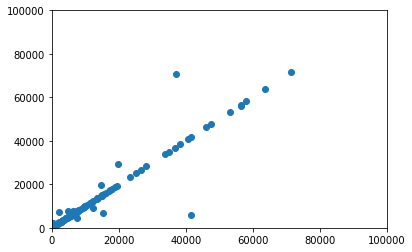

In [67]:
plt.scatter(y_model_fitted, yd)
plt.xlim(0, 100000)
plt.ylim(0, 100000)

Ok, the correlation is almost the same as above, but now we do not overestimate so much. Let's apply it to the dataset as a whole.

# Applying population estimates to the whole dataset

Let's repeat the formula for estimating population sizes

(1) <i> N = dA<sup>p</sup>  </i>,

where *N* is size of the estimated population, *d* is base coefficient for inhabitants per area, *A* is size of the area in hectares, and exponent *p* makes the hard work of modifying the density per area. To avoid confussion, here we use `dens` instead of *d* and `exp` instead of `p`

In [68]:
exp = 1.336068 ### see above
dens = 41.8398 ### see above
def get_pop_est(row):
    area = row["Area"]
    try: 
        pop_est = round(dens * (area**exp), 0)
        if math.isnan(area):
            pop_est = 1000
    except: 
        pop_est = 1000
    return pop_est
cities_pop["pop_est"] = cities_pop.apply(lambda row: get_pop_est(row), axis=1)

In [69]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'Name', 'Area (ha)',
       'Population', 'Forum/agoraarea(m2)', 'Streetarea(m2)',
       'Streetlength(m)', 'Streetwidth(m)', 'Blockarea(m2)', 'pop_est'],
      dtype='object')

In [70]:
cities_pop.drop(['Name', 'Area (ha)',
       'Forum/agoraarea(m2)', 'Streetarea(m2)', 'Streetlength(m)',
      'Streetwidth(m)', 'Blockarea(m2)',], axis=1, inplace=True)

In [71]:
cities_pop.rename({"Population":"pop_sample"}, axis=1, inplace=True)

In [72]:
def get_pop_diff(row):
  try: return abs(row["pop_sample"] / row["pop_est"])
  except: return 0
cities_pop["pop_diff"] = cities_pop.apply(lambda row: get_pop_diff(row), axis=1)
cities_pop.sort_values("pop_diff", ascending=False).head(10)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),...,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID,pop_sample,pop_est,pop_diff
673,Hanson2016_674,Noviodunum (Germania Superior),Nyon,Germania Superior,Switzerland,4 or 5,18 D3,-49,NaN,6.238391,...,Bedon 2001; Bedon et al 1988; BNP; Cornell and...,6.0,Urban grid,"[Colonia, Rights and privileges]","[Basilica, Baths, Forum, Forum, Macellum, Mith...",8,674,2290.0,458.0,5.000000
775,Hanson2016_776,Herculaneum,Ercolano,Italia (I Latium and Campania),Italy,3,44 F4,-600,79.0,14.347143,...,Beloch 1880; Bispham 2007; de Ligt 2012; DGRG;...,20.0,Unspecified,[Municipium],"[Arch, Arch, Basilica, Baths, Baths, Baths (Ce...",14,776,7401.0,2290.0,3.231878
1161,Hanson2016_1162,Thessalonica,Thessaloniki,Macedonia,Greece,1,50 C3,-316,NaN,22.945540,...,Cohen 1995; McEvedy 2011; Nelis-Clément and Ro...,161.0,Urban grid and walls (Late Roman),"[Colonia, Metropolis capital, Provincial capit...","[Acropolis, Agora, Arch, Arch of Galerius, Bas...",17,1162,70860.0,37159.0,1.906940
1047,Hanson2016_1048,Brixia,Brescia,Italia (X Venetia et Histria),Italy,2,39 G2,-89,NaN,10.219836,...,Beloch 1880; Cornell and Mathews 1982; de Ligt...,35.0,Urban grid,"[Colonia, Municipium]","[Basilica, Forum, Sanctuary, Temple, Temple ('...",8,1048,7790.0,4837.0,1.610502
1157,Hanson2016_1158,Pella (Macedonia),Pella,Macedonia,Greece,2,50 C3,-413,NaN,22.525641,...,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,100.0,"Urban grid, 1,000 by 1,000","[Colonia, Colonia, Rights and privileges, Righ...","[Acropolis, Agora, Sanctuary of Aphrodite and ...",8,1158,29368.0,19666.0,1.493339
1170,Hanson2016_1171,Cuicul,Djemila,Mauretania Caesariensis,Algeria,3,31 D4,96,NaN,5.735732,...,BNP; DGRG; Lepelley 1979-1981; PECS; Quinn and...,9.0,Inhabited area,"[Colonia, Colonia]","[Aqueduct, Arch, Arch of Caracalla, Basilica, ...",19,1171,1157.0,788.0,1.468274
342,Hanson2016_343,Iluro,Mataró,Baetica,Spain,3,26 F5,-100,NaN,-4.706673,...,Brunt 1971; Carreras Monfort 1995-1996; Cornel...,8.0,Urban grid,"[Municipium, Rights and privileges]","[Baths, Forum, Fountain, Urban grid]",4,343,907.0,673.0,1.347697
1044,Hanson2016_1045,Aquileia,Aquileia,Italia (X Venetia et Histria),Italy,2,19 F4,-181,NaN,13.367051,...,Beloch 1880; Beloch 1886; Bispham 2007; Cornel...,80.0,Walls of Julian the Apostate,"[Colonia, Colonia, Colonia?, Municipium, Right...","[Amphitheatre, Basilica, Baths, Baths (Large),...",18,1045,19667.0,14596.0,1.347424
1020,Hanson2016_1021,Placentia,Piacenza,Italia (VIII Aemilia),Italy,2,39 F3,-218,NaN,9.693115,...,Beloch 1880; Bispham 2007; Cornell and Mathews...,43.0,Urban grid,"[Colonia, Colonia, Colonia, Municipium, Rights...","[Amphitheatre, Capitolium, Forum?, Macellum, U...",7,1021,7790.0,6368.0,1.223304
1132,Hanson2016_1133,Sagalassus,Aglasun,Lycia et Pamphylia,Turkey,2,65 E2,-323,NaN,30.519188,...,BNP; DGRG; Hanson 2011; Jones 1937; PECS; Sear...,20.0,Inhabited area,[Rights and privileges],"[Acropolis, Agora, Agora, Baths, Bouleuterion,...",18,1133,2601.0,2290.0,1.135808


In [73]:
cities_pop

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),...,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID,pop_sample,pop_est,pop_diff
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,...,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,1,NaN,1700.0,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,...,BNP; DGRG; PECS; Sear 2006.,NaN,NaN,NaN,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,2,NaN,1000.0,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,...,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,NaN,NaN,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,3,NaN,1000.0,NaN
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,...,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,4,NaN,8209.0,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,...,DGRG; Hansen and Nielsen 2004.,NaN,NaN,NaN,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,5,NaN,1000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,Hanson2016_1384,Pautalia,Kyustendi,Thracia,Bulgaria,3,49 E1,98,NaN,22.680752,...,BNP; DGRG; Jones 1937; PECS; Wilkes 2003b.,NaN,NaN,[Rights and privileges],"[Acropolis, Baths, Forum, Gymnasium, Temple of...",11,1384,NaN,1000.0,NaN
1384,Hanson2016_1385,Philippopolis (Thracia),Plovdiv,Thracia,Bulgaria,2,22 B6,-342,NaN,24.750913,...,BNP; Cohen 1995; DGRG; Hansen and Nielsen 2004...,78.0,Walls,"[Colonia, Metropolis capital, Provincial capital]","[Acropolis, Agora, Aqueduct, Baths, Hippodrome...",12,1385,NaN,14111.0,NaN
1385,Hanson2016_1386,Samothrace,Samothrace,Thracia,Greece,3,51 F3,-700,NaN,25.529249,...,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,26.0,Walls,[Rights and privileges],"[Acropolis, Sanctuary of the Great Gods, Stoa,...",6,1386,NaN,3252.0,NaN
1386,Hanson2016_1387,Serdica,Sophia,Thracia,Bulgaria,2,21 F7,45,NaN,23.342891,...,BNP; DGRG; Jones 1937; PECS; Sear 2006; Wilkes...,84.0,Inhabited area,"[Colonia, Rights and privileges]","[Amphitheatre, Basilica, Baths, Bouleuterion, ...",9,1387,NaN,15580.0,NaN


In [74]:
### how many city inhabitants we have
cities_pop["pop_est"].sum()

10159670.0

In [75]:
sddk.write_file("SDAM_data/urban/roman_cities.json", cities_pop, conf)

A file with the same name ("roman_cities.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/roman_cities.json"
